# Google vit-large-patch32-384 AI Model for Image classification (1000 classes)

Testing with and without CUDA Graph from PyTorch on one Image and on multiple Images

In [1]:
!pip install accelerate

In [1]:
from transformers import ViTFeatureExtractor, ViTForImageClassification

import torch
from torch.profiler import profile, record_function, ProfilerActivity
import torchvision

from PIL import Image
import matplotlib.pyplot as plt
import time
import os

# check gpu
if torch.cuda.is_available():
    device = 'cuda'
else:
    device = 'cpu'

print(device)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-large-patch32-384')
model = ViTForImageClassification.from_pretrained('google/vit-large-patch32-384', device_map=device)

model.eval()

cuda


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(32, 32), stride=(32, 32))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_f

## Test with 1 Image on GPU

### Warmup

In [3]:
# loads an images from file
input = []
dir = "./images"

for image in os.listdir(dir):
    image = Image.open(os.path.join(dir, image))
    img = feature_extractor(images=image, return_tensors="pt")
    input.append(img['pixel_values'])
    if len(input) == 10:
        break

### Without CUDA Graph

In [4]:
start_time = time.perf_counter()
# warmup
for i in range(10):
    with torch.no_grad():
        output = model(input[1].to(device))
        logits = output.logits
torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=0, warmup=0, active=1, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/t4/one_image/no_cuda_graph'),
    record_shapes=True,
) as prof:
    with record_function("model_inference"):
        # make prediction
        output = model(input[1].to(device))
        logits = output.logits

        torch.cuda.synchronize()

        # model predicts one of the 1000 ImageNet classes
        predicted_class_idx = logits.argmax(-1).item()
        prof.step()

        end_time = time.perf_counter()

print("Predicted class:", model.config.id2label[predicted_class_idx])
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")

/usr/local/lib/python3.10/dist-packages/torch/profiler/profiler.py:339: UserWarning: Profiler won't be using warmup, this can skew profiler results
  warn("Profiler won't be using warmup, this can skew profiler results")


Predicted class: brambling, Fringilla montifringilla
Time: 0.5057174359999976
Time with warmup: 1.769527792999952


### With CUDA Graph

In [5]:
static_input = torch.rand(1, 3, 384, 384, device=device)
static_input.copy_(input[1])

start_time = time.perf_counter()
# warmup
s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for i in range(10):
        static_output = model(static_input).logits
torch.cuda.current_stream().wait_stream(s)

torch.cuda.synchronize()

# capture
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
        static_output = model(static_input).logits

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=0, warmup=0, active=1, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/t4/one_image/cuda_graph'),
    record_shapes=True,
) as prof:

    with record_function("copy data"):
        static_input.copy_(input[1])

    with record_function("model_inference"):
        # replay graph
        g.replay()

        torch.cuda.synchronize()

        # model predicts one of the 1000 ImageNet classes
        predicted_class_idx = logits.argmax(-1).item()
        prof.step()

    end_time = time.perf_counter()

print("Predicted class:", model.config.id2label[predicted_class_idx])
print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")

Predicted class: brambling, Fringilla montifringilla
Time: 0.07383008200002905
Time with warmup: 1.047373112999992


### Show image for comparison

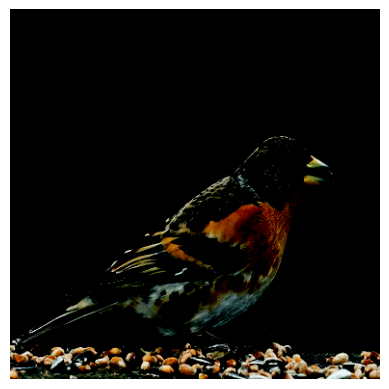

In [6]:
numpy_image = input[1].cpu().detach().squeeze(0).permute(1, 2, 0).numpy()
plt.imshow(numpy_image)
plt.axis('off')
plt.show()

## Test with many Images

In [2]:
folder_dir = "./images"
images = [os.path.join(folder_dir, file_name) for file_name in os.listdir(folder_dir) if file_name.endswith(".JPEG")]

### Without CUDA Graph

In [8]:
count = 0
pred = {}

start_time = time.perf_counter()
# warmup
inputs = feature_extractor(images=Image.open(images[0]), return_tensors="pt")
inputs = inputs['pixel_values'].to(device)
with torch.no_grad():
    for i in range(10):
        outputs = model(inputs).logits
torch.cuda.synchronize()


start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=3, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/t4/many_images/no_cuda_graph'),
    record_shapes=True,
) as prof:

    for i in range(len(images)):
        with record_function("load_image"):
            input_image = Image.open(images[i])

        with record_function("feature_extractor"):
            # convert image to tensor and put on gpu
            inputs = feature_extractor(images=input_image, return_tensors="pt")
            inputs = inputs['pixel_values'].to(device)

        with torch.no_grad(), record_function("model_inference"):
            # make prediction
            outputs = model(inputs).logits

            with record_function("synchronize"):
                torch.cuda.synchronize()

            with record_function("save_prediction"):
                # add prediction and filename to dictionary
                pred[images[i]] = model.config.id2label[outputs.argmax(-1).item()]

        count += 1
        prof.step()

    end_time = time.perf_counter()

print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")
print("Predicted images:", count)

Time: 14.155231001999994
Time with warmup: 14.50816654800002
Predicted images: 149


In [9]:
# print all predictions
for key, value in pred.items():
    print(f"{key}: {value}", end=", ")
    print()

./images/ILSVRC2012_val_00007574.JPEG: tree frog, tree-frog, 
./images/ILSVRC2012_val_00002023.JPEG: brambling, Fringilla montifringilla, 
./images/ILSVRC2012_val_00005590.JPEG: whiptail, whiptail lizard, 
./images/ILSVRC2012_val_00027776.JPEG: alligator lizard, 
./images/ILSVRC2012_val_00038449.JPEG: common newt, Triturus vulgaris, 
./images/ILSVRC2012_val_00037560.JPEG: box turtle, box tortoise, 
./images/ILSVRC2012_val_00000963.JPEG: magpie, 
./images/ILSVRC2012_val_00003169.JPEG: great grey owl, great gray owl, Strix nebulosa, 
./images/ILSVRC2012_val_00027514.JPEG: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias, 
./images/ILSVRC2012_val_00001598.JPEG: robin, American robin, Turdus migratorius, 
./images/ILSVRC2012_val_00004897.JPEG: box turtle, box tortoise, 
./images/ILSVRC2012_val_00027831.JPEG: junco, snowbird, 
./images/ILSVRC2012_val_00020822.JPEG: goldfish, Carassius auratus, 
./images/ILSVRC2012_val_00014917.JPEG: cock, 
./images/ILSVRC2

### With CUDA Graph

In [10]:
count = 0
pred = {}

static_input = torch.rand(1, 3, 384, 384).to(device)

start_time = time.perf_counter()
# warmup
inputs = feature_extractor(images=Image.open(images[0]), return_tensors="pt")
static_input.copy_(inputs['pixel_values'])

s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.no_grad(), torch.cuda.stream(s):
    for i in range(10):
        static_output = model(static_input).logits
torch.cuda.current_stream().wait_stream(s)
torch.cuda.synchronize()

# capture graph
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    static_output = model(static_input).logits

torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=3, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/t4/many_images/cuda_graph'),
    record_shapes=True,
) as prof:

    for i in range(len(images)):
        with record_function("load_image"):
            input_image = Image.open(images[i])

        with record_function("feature_extractor"):
            # convert image to tensor and copy to gpu
            inputs = feature_extractor(images=input_image, return_tensors="pt")
            static_input.copy_(inputs['pixel_values'])

        with record_function("model_inference"):
            # replay graph
            g.replay()

            with record_function("synchronize"):
                torch.cuda.synchronize()

            with record_function("save_prediction"):
                # add prediction and filename to dictionary
                pred[images[i]] = model.config.id2label[static_output.argmax(-1).item()]

        count += 1
        prof.step()

    end_time = time.perf_counter()

print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")
print("Predicted images:", count)

Time: 8.926668816000017
Time with warmup: 10.173847000000023
Predicted images: 149


In [11]:
# print all predictions
for key, value in pred.items():
    print(f"{key}: {value}", end=", ")
    print()

./images/ILSVRC2012_val_00007574.JPEG: tree frog, tree-frog, 
./images/ILSVRC2012_val_00002023.JPEG: brambling, Fringilla montifringilla, 
./images/ILSVRC2012_val_00005590.JPEG: whiptail, whiptail lizard, 
./images/ILSVRC2012_val_00027776.JPEG: alligator lizard, 
./images/ILSVRC2012_val_00038449.JPEG: common newt, Triturus vulgaris, 
./images/ILSVRC2012_val_00037560.JPEG: box turtle, box tortoise, 
./images/ILSVRC2012_val_00000963.JPEG: magpie, 
./images/ILSVRC2012_val_00003169.JPEG: great grey owl, great gray owl, Strix nebulosa, 
./images/ILSVRC2012_val_00027514.JPEG: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias, 
./images/ILSVRC2012_val_00001598.JPEG: robin, American robin, Turdus migratorius, 
./images/ILSVRC2012_val_00004897.JPEG: box turtle, box tortoise, 
./images/ILSVRC2012_val_00027831.JPEG: junco, snowbird, 
./images/ILSVRC2012_val_00020822.JPEG: goldfish, Carassius auratus, 
./images/ILSVRC2012_val_00014917.JPEG: cock, 
./images/ILSVRC2

prepairing next image, while cpu is idle waiting for gpu to finish prediction

In [3]:
count = 1
pred = {}

static_input = torch.rand(1, 3, 384, 384).to(device)

start_time = time.perf_counter()
# warmup
inputs = feature_extractor(images=Image.open(images[0]), return_tensors="pt")
static_input.copy_(inputs['pixel_values'])

s = torch.cuda.Stream()
s.wait_stream(torch.cuda.current_stream())
with torch.cuda.stream(s):
    for i in range(10):
        static_output = model(static_input).logits
torch.cuda.current_stream().wait_stream(s)
torch.cuda.synchronize()

# capture graph
g = torch.cuda.CUDAGraph()
with torch.cuda.graph(g):
    static_output = model(static_input).logits

torch.cuda.synchronize()

start_time1 = time.perf_counter()
benchmark_schedule = torch.profiler.schedule(wait=20, warmup=3, active=5, repeat=1)
with torch.no_grad(), torch.profiler.profile(
    schedule=benchmark_schedule,
    on_trace_ready=torch.profiler.tensorboard_trace_handler(f'./log/t4/many_images/cuda_graph_next_image'),
    record_shapes=True,
) as prof:

    # load first image
    with record_function("load_image"):
        input_image = Image.open(images[0])

    with record_function("feature_extractor"):
        # convert image to tensor and copy to gpu
        inputs = feature_extractor(images=input_image, return_tensors="pt")
        static_input.copy_(inputs['pixel_values'])

    for i in range(1, len(images)):
        with record_function("model_inference"):
            # replay graph
            g.replay()

            # load next image
            with record_function("load_next_image_and_feature_extractor"):
                input_image = Image.open(images[i])
                inputs = feature_extractor(images=input_image, return_tensors="pt")

            with record_function("synchronize"):
                torch.cuda.synchronize()

            with record_function("save_prediction"):
                # add prediction and filename to dictionary
                pred[count] = model.config.id2label[static_output.argmax(-1).item()]

            with record_function("copy_data"):
                static_input.copy_(inputs['pixel_values'])

        count += 1
        prof.step()

    # predict last image
    with record_function("model_inference"):
            # replay graph
            g.replay()

    with record_function("save_prediction"):
            # add prediction and filename to dictionary
            pred[count] = model.config.id2label[static_output.argmax(-1).item()]

    end_time = time.perf_counter()

print(f"Time: {end_time - start_time1}")
print(f"Time with warmup: {end_time - start_time}")
print("Predicted images:", count)

Time: 6.8106901140000105
Time with warmup: 8.099633363999999
Predicted images: 149


In [4]:
# print all predictions
for key, value in pred.items():
    print(f"{key}: {value}", end=", ")
    print()

1: tree frog, tree-frog, 
2: brambling, Fringilla montifringilla, 
3: whiptail, whiptail lizard, 
4: alligator lizard, 
5: common newt, Triturus vulgaris, 
6: box turtle, box tortoise, 
7: magpie, 
8: great grey owl, great gray owl, Strix nebulosa, 
9: great white shark, white shark, man-eater, man-eating shark, Carcharodon carcharias, 
10: robin, American robin, Turdus migratorius, 
11: box turtle, box tortoise, 
12: junco, snowbird, 
13: goldfish, Carassius auratus, 
14: cock, 
15: kite, 
16: common newt, Triturus vulgaris, 
17: magpie, 
18: hammerhead, hammerhead shark, 
19: leatherback turtle, leatherback, leathery turtle, Dermochelys coriacea, 
20: indigo bunting, indigo finch, indigo bird, Passerina cyanea, 
21: axolotl, mud puppy, Ambystoma mexicanum, 
22: loggerhead, loggerhead turtle, Caretta caretta, 
23: beer glass, 
24: hen, 
25: mud turtle, 
26: hen, 
27: whiptail, whiptail lizard, 
28: junco, snowbird, 
29: loggerhead, loggerhead turtle, Caretta caretta, 
30: robin, Ameri

## Profiler to check CUDA Graph capture

In [5]:
with profile(activities=[ProfilerActivity.CPU, ProfilerActivity.CUDA]) as prof:
    # capture graph
    g = torch.cuda.CUDAGraph()
    with torch.cuda.graph(g):
        static_output = model(static_input).logits

prof.export_chrome_trace(f"log/rtx3080/CUDAGraph_capture_rtx3080.json")